In [1]:
%matplotlib inline
import player as data_pl
import team as data_te
import game as data_ga
import utils as anal_ut
import multiprocessing as mp
import numpy as np
import scipy
import scipy.stats as scst
import datetime
from numpy import linalg
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import matplotlib.colors as colors
import pandas as pd
import time
from sklearn import cluster
from sklearn import linear_model
from collections import Counter
import math
import statsmodels.api as sm
import urllib2
import re
import os
import unicodedata
import pulp_lineup_optimization as lopt
from scipy import special
import cvxopt
import dfs_utils as dfsutils
DFS_SITES = dfsutils.DFS_SITES

In [23]:
with open('pid2pos.txt', 'r') as reader:
    pid2pos = eval(reader.read())
        
global_stats = pd.read_csv('global_stats.csv', index_col=0)
global_stats.GAME_DATE = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in global_stats.GAME_DATE]
global_stats = global_stats.sort('GAME_DATE', ascending=True)

In [10]:
today = datetime.date(2015, 12, 12)
whole_start_time = time.time()
while today < datetime.datetime.now().date():
    start_time = time.time()
    try:
        pl = dfsutils.get_player_list(today)
    except:
        try:
            pl = pd.read_csv('PlayerLists/pl_fd_nba_%02d_%02d_%4d.csv' % (today.month, today.day, today.year))
        except:
            print 'Missing', today
            today += datetime.timedelta(days=1)
            continue
        del pl['Id']
        del pl['Unnamed: 12']
        del pl['Unnamed: 13']
    pl = pl.drop_duplicates()
    pl.Game = [dfsutils.fix_game_abbrev(x) for x in pl.Game]
    pl.Team = [dfsutils.fix_team_abbrev[x] if x in dfsutils.fix_team_abbrev else x for x in pl.Team]
    pl.Opponent = [dfsutils.fix_team_abbrev[x] if x in dfsutils.fix_team_abbrev else x for x in pl.Opponent]
    pl['LAST_COMMA_FIRST'] = ['%s, %s' % (l,f) for l,f in zip(pl['Last Name'],pl['First Name'])]
    pl['LAST_COMMA_FIRST'] = [x if x not in dfsutils.COMMA_NAME_CORRECTIONS else dfsutils.COMMA_NAME_CORRECTIONS[x] for x in pl.LAST_COMMA_FIRST]
    pl['Player_ID'] = [dfsutils.get_pid(x) for x in pl.LAST_COMMA_FIRST]
#     pl['FD_Salary'] = [float(x) for x in pl.Salary]
#     pl['FD_Position'] = pl['Position']
    pl = pl.set_index('Player_ID')
    pl = pl.groupby(pl.index).first()

    filename = 'Parameters/player_parameters_%s.csv' % today
    player_params = pd.read_csv(filename, index_col=False)
    player_params = player_params.set_index('PERSON_ID')

    with open('AdjustmentRegressions/opp_vs_pos_%s' % today, 'r') as reader:
        tvp_adj = eval(reader.read().replace('array','np.array'))

    global_stats = global_stats.sort('GAME_DATE', ascending=True)
    tmp = global_stats[global_stats.GAME_DATE < today]
    projs = pd.DataFrame()
    for row_num, row in pl.iterrows():
        if np.isnan(row.name):
            print row.LAST_COMMA_FIRST, ' has nan pid'
            continue
        pid = int(row.name)

        team_abbr = row.Team

        # Estimate Playing Time
        tmpsub = tmp[tmp.Player_ID == pid]
        if len(tmpsub) == 0:
            print row.LAST_COMMA_FIRST, 'has no data'
            continue
        if len(tmpsub.MIN.iloc[-7:])>0:
            mins = .5*(tmpsub.MIN.iloc[-7:].median() + tmpsub.MIN.iloc[-7:].mean())
            tmpsub2 = tmpsub[tmpsub.GAME_DATE >= datetime.date(2015, 7, 7)].sort('MIN')
            ngames = len(tmpsub2.MIN)
            try:
                mad = np.median(np.abs(tmpsub2.MIN - tmpsub2.MIN.median()))
                floor_mins = tmpsub2.MIN.iloc[ngames/10]
                ceil_mins  = tmpsub2.MIN.iloc[(9*ngames+1)/10]
            except:
                floor_mins = np.maximum(mins - 10, 0)
                ceil_mins = mins + 5
        else:
            print row.LAST_COMMA_FIRST
            mins = 0
            floor_mins = 0
            ceil_mins = 20

        params = player_params.loc[pid].copy()
        rates = dfsutils.params2rates(pd.DataFrame(params).T)

        try:
            adj = tvp_adj[pid2pos[pid]][row.Opponent]
            proj = dfsutils.rates_mins2projs(rates, mins, adj)
            unadj = dfsutils.rates_mins2projs(rates, mins)
            for SITE in dfsutils.DFS_SITES:
                proj['UNADJ_%s'%SITE] = unadj[SITE]
            floor_proj = dfsutils.rates_mins2projs(rates, floor_mins, adj)
            ceil_proj  = dfsutils.rates_mins2projs(rates, ceil_mins,  adj)
            proj['FLOOR_MIN'] = floor_mins
            proj['CEIL_MIN'] = ceil_mins
            for site in DFS_SITES:
                proj['FLOOR_%s'%site] = floor_proj[site]
                proj['CEIL_%s'%site] = ceil_proj[site]
            tmpsubseason = tmpsub[tmpsub.SEASON_ID==22015]
            proj['HIST_FD_Skew'] = tmpsubseason.FD.skew()
            proj['HIST_FD_Kurt'] = tmpsubseason.FD.kurt()
            minstd = np.std(tmpsubseason.MIN, ddof=1)
            if np.isnan(minstd):
                minstd = 40.
            proj['HIST_MIN_std'] = minstd
            proj['HIST_FD_std'] = np.std(tmpsubseason.FD, ddof=1)
            proj['Bust5'] = np.mean(tmpsub.FD.iloc[-5:]  <=.0035*pl.loc[pid].FD_Salary)
            proj['Bust10'] = np.mean(tmpsub.FD.iloc[-10:]<=.0035*pl.loc[pid].FD_Salary)
            proj['Bust20'] = np.mean(tmpsub.FD.iloc[-20:]<=.0035*pl.loc[pid].FD_Salary)
            proj['Boom5'] = np.mean(tmpsub.FD.iloc[-5:]  >=.005*pl.loc[pid].FD_Salary)
            proj['Boom10'] = np.mean(tmpsub.FD.iloc[-10:]>=.005*pl.loc[pid].FD_Salary)
            proj['Boom20'] = np.mean(tmpsub.FD.iloc[-20:]>=.005*pl.loc[pid].FD_Salary)
        except KeyError:
            print row.LAST_COMMA_FIRST, ' pid not in pid2pos'
            continue
        proj = pd.DataFrame(proj, columns=[pid]).T
        proj.columns = ['PROJ_%s' % x for x in proj.columns]
        proj['Player_ID'] = pid
        proj = proj.set_index('Player_ID')
        projs = projs.append(proj)

    projs2 = projs.copy()
    # TODO: Value plays
    overrides = {
        # LAST_COMMA_FIRST : MIN
    }

    increases = {
        # LCF : (plus, times)
    }

    filename = 'Parameters/player_parameters_%s.csv' % today
    player_params = pd.read_csv(filename, index_col=False)
    player_params = player_params.set_index('PERSON_ID')
    tmp = global_stats[global_stats.GAME_DATE < today]
    for lcf, mins in overrides.iteritems():
        pid = dfsutils.get_pid(lcf)
        if np.isnan(pid):
            print lcf, ' has nan pid'
            continue
        pid = int(pid)

        try:
            row = pl.loc[pid]
        except:
            print lcf, 'not found'
            continue

        params = player_params.loc[pid].copy()
        rates = dfsutils.params2rates(pd.DataFrame(params).T)

        try:
            proj = dfsutils.rates_mins2projs(rates, mins, tvp_adj[pid2pos[pid]][row.Opponent])
            unadj = dfsutils.rates_mins2projs(rates, mins)
            for SITE in dfsutils.DFS_SITES:
                proj['UNADJ_%s'%SITE] = unadj[SITE]
        except KeyError:
            print row.LAST_COMMA_FIRST, ' pid not in pid2pos'
            continue
        proj = pd.DataFrame(proj, columns=[pid]).T
        proj.columns = ['PROJ_%s' % x for x in proj.columns]
        proj['Player_ID'] = pid
        proj = proj.set_index('Player_ID')

        for col in proj.columns:
            projs2.set_value(pid, col, proj[col].iloc[0])

    PROJS = pl.merge(projs2, left_index=True, right_index=True)

    for name, s in increases.iteritems():
        f, r = s
        pid = dfsutils.get_pid(name)
        for site in DFS_SITES:
            PROJS.set_value(pid, 'PROJ_%s'%site, f + r*PROJS.loc[pid]['PROJ_%s'%site])

    for SITE in dfsutils.DFS_SITES:
        PROJS['ADJ_%s'%SITE] = (PROJS['PROJ_%s'%SITE] - PROJS['PROJ_UNADJ_%s'%SITE])
    PROJS['Injury Indicator'] = PROJS['Injury Indicator'].fillna('')
    PROJS['Injury Details'] = PROJS['Injury Details'].fillna('')
    PROJS['Status'] = [' - '.join([x,y]) if x != '' else '-' for x,y in zip(PROJS['Injury Indicator'],PROJS['Injury Details'])]

    PROJS.to_csv('MultiSiteProjections/nba_%s.csv' % today)
    
    print today, time.time()-start_time, whole_start_time - time.time()
    today += datetime.timedelta(days=1)

Webster, Martell
pl_dk_nba_2015-12-12.csv not found
pl_yh_nba_2015-12-12.csv not found
pl_dp_nba_2015-12-12.csv not found
pl_dd_nba_2015-12-12.csv not found
['BOS@CHA' 'GSW@MIL' 'IND@DET' 'LAL@HOU' 'NOP@CHI' 'NYK@POR' 'SAS@ATL'
 'WAS@DAL']
['BOS@CHA' 'GSW@MIL' 'IND@DET' 'LAL@HOU' 'NOP@CHI' 'NYK@POR' 'SAS@ATL'
 'WAS@DAL']
['BOS@CHA' 'GSW@MIL' 'IND@DET' 'LAL@HOU' 'NOP@CHI' 'NYK@POR' 'SAS@ATL'
 'WAS@DAL']
local variable 'dp' referenced before assignment
['BOS@CHA' 'GSW@MIL' 'IND@DET' 'LAL@HOU' 'NOP@CHI' 'NYK@POR' 'SAS@ATL'
 'WAS@DAL']
['BOS@CHA' 'GSW@MIL' 'IND@DET' 'LAL@HOU' 'NOP@CHI' 'NYK@POR' 'SAS@ATL'
 'WAS@DAL']
Hayes, Charles has no data
Christmas, Rakeem has no data
2015-12-12 396.024266958 -396.037858963
Sampson, Jakarr
pl_dk_nba_2015-12-13.csv not found
pl_yh_nba_2015-12-13.csv not found
pl_dp_nba_2015-12-13.csv not found
pl_dd_nba_2015-12-13.csv not found
['MEM@MIA' 'MIN@PHX' 'PHI@TOR' 'UTA@OKC']
['MEM@MIA' 'MIN@PHX' 'PHI@TOR' 'UTA@OKC']
['MEM@MIA' 'MIN@PHX' 'PHI@TOR' 'UTA@OKC']


/Library/Python/2.7/site-packages/pandas/core/ops.py:562: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  result = lib.scalar_compare(x, y, op)
/Library/Python/2.7/site-packages/pandas/core/generic.py:2177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value



['ATL@PHX' 'CHI@CLE' 'DET@DEN' 'IND@SAC' 'LAL@POR' 'MEM@MIN' 'MIL@NOP']
['ATL@PHX' 'CHI@CLE' 'DET@DEN' 'IND@SAC' 'LAL@POR' 'MEM@MIN' 'MIL@NOP']
['ATL@PHX' 'CHI@CLE' 'DET@DEN' 'IND@SAC' 'LAL@POR' 'MEM@MIN' 'MIL@NOP']
['ATL@PHX' 'CHI@CLE' 'DET@DEN' 'IND@SAC' 'LAL@POR' 'MEM@MIN' 'MIL@NOP']
['ATL@PHX' 'CHI@CLE' 'DET@DEN' 'IND@SAC' 'LAL@POR' 'MEM@MIN' 'MIL@NOP']
Williams, Elliot has no data
Green, Erick has no data
Brown, Lorenzo has no data
Kilpatrick, Sean has no data
Christmas, Rakeem has no data
Dukan, Duje has no data
2016-01-23 382.19406414 -15329.4535131
Sampson, Jakarr
Sampson, Jakarr
Sampson, Jakarr
Walker, Chris
Kazemi, Arsalan
Scott, Shannon
Famous, Jarrid
Tyler, Jeremy
Ashley, Brandon
Stone, Julyan
Qualls, Michael
Wells, Dez
Roberts, Ronald
Cummings, Will
Harper, Justin
Jones, Dahntay
Zanna, Talib
Wilson, Jamil
Dalembert, Samuel
Kyser, Michale
Smith, Joshua
Toupane, Axel
Sampson, Jakarr
Sampson, Jakarr
Series([], Name: LAST_COMMA_FIRST, dtype: object)
['BOS@PHI' 'DAL@HOU' 'LAC@

In [17]:
columns = ['PROJ_FD','PROJ_UNADJ_FD','PROJ_MIN','ADJ_FD']
iter_date = datetime.date(2015, 10, 27)

master = pd.DataFrame()
while iter_date <= datetime.date(2016, 1, 27):
    try:
        tmp = pd.read_csv('MultiSiteProjections/nba_%s.csv' % iter_date, index_col=False)
    except IOError, e:
        print e.message
        iter_date += datetime.timedelta(days=1)
        continue
    index = pd.MultiIndex.from_tuples([(iter_date, int(pid)) for pid in tmp.Player_ID])
    tmp = tmp.set_index(index)
    master = master.append(tmp[columns])
    iter_date += datetime.timedelta(days=1)

File MultiSiteProjections/nba_2015-10-29.csv does not exist
File MultiSiteProjections/nba_2015-11-26.csv does not exist
File MultiSiteProjections/nba_2015-12-03.csv does not exist
File MultiSiteProjections/nba_2015-12-06.csv does not exist
File MultiSiteProjections/nba_2015-12-07.csv does not exist
File MultiSiteProjections/nba_2015-12-08.csv does not exist
File MultiSiteProjections/nba_2015-12-09.csv does not exist
File MultiSiteProjections/nba_2015-12-10.csv does not exist
File MultiSiteProjections/nba_2015-12-11.csv does not exist
File MultiSiteProjections/nba_2015-12-24.csv does not exist


/Users/andingo/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:9: DeprecationWarning: BaseException.message has been deprecated as of Python 2.6


In [36]:
for dtstr in master.index.levels[0]:
    dt = datetime.datetime.strptime(str(dtstr), '%Y-%m-%d %H:%M:%S').date()
    sub = global_stats[global_stats.GAME_DATE==dt]
    for pid in master.loc[dt].index:
        try:
            sub2 = sub[sub.Player_ID==pid].iloc[0]
            for x in ('MIN','FD'):
                master.set_value((dt, pid), x, sub2[x])
        except IndexError:
            for x in ('MIN','FD'):
                master.set_value((dt, pid), x, 0)

In [38]:
tab = master.copy()

In [53]:
tab['ADJ_MIN'] = tab.ADJ_FD / tab.PROJ_MIN
tab['PROJ_UNADJ_FD_MIN'] = tab.PROJ_UNADJ_FD / tab.PROJ_MIN
tab['FD_MIN'] = tab.FD / tab.MIN
tab['PROJ_FD_MIN'] = tab.PROJ_FD / tab.PROJ_MIN

In [54]:
table = tab[tab.MIN > 0]
table = table.reset_index(drop=False)
table = table.rename(columns={'level_0':'GAME_DATE', 'level_1':'Player_ID'})
table

,GAME_DATE,Player_ID,PROJ_FD,PROJ_UNADJ_FD,PROJ_MIN,ADJ_FD,MIN,FD,ADJ_MIN,FD_MIN,PROJ_FD_MIN,PROJ_UNADJ_FD_MIN
0,2015-10-27,2200,37.942701,38.396128,33.785714,-0.453426,32,18.4,-0.013421,0.575000,1.123040,1.136460
1,2015-10-27,2210,15.016877,15.355828,24.714286,-0.338950,17,12.5,-0.013715,0.735294,0.607619,0.621334
2,2015-10-27,2544,41.524669,44.112626,36.071429,-2.587957,36,45.5,-0.071745,1.263889,1.151179,1.222924
3,2015-10-27,2570,8.783194,8.557235,13.642857,0.225959,16,16.3,0.016562,1.018750,0.643794,0.627232
4,2015-10-27,2571,13.526031,14.149964,18.285714,-0.623932,21,9.2,-0.034121,0.438095,0.739705,0.773826
5,2015-10-27,2581,10.785737,10.049781,16.214286,0.735956,16,8.0,0.045389,0.500000,0.665200,0.619810
6,2015-10-27,2590,21.600237,21.133871,24.071429,0.466367,37,37.3,0.019374,1.008108,0.897339,0.877965
7,2015-10-27,2592,7.158242,7.584743,13.142857,-0.426501,4,2.0,-0.032451,0.500000,0.544649,0.577100
8,2015-10-27,2594,18.766317,18.490221,27.142857,0.276096,29,11.9,0.010172,0.410345,0.691391,0.681219
9,2015-10-27,2733,13.909209,14.773563,19.714286,-0.864353,21,14.6,-0.043844,0.695238,0.705540,0.749384


In [101]:
d = {'LCF':[], 'Corr':[], 'Mean':[], 'Std':[]}
for pid in np.unique(table.Player_ID):
    pid = int(pid)
    lcf = dfsutils.get_lcf(pid)

    pt = table[table.Player_ID==pid]
    c = np.corrcoef(pt.ADJ_MIN*pt.MIN, (pt.FD_MIN-pt.PROJ_UNADJ_FD_MIN)*pt.MIN)[0,1]
    
#     print '%25s\t' % lcf,
#     print 'Corr: %.3f' % c
    d['LCF'].append(lcf)
    d['Corr'].append(c)
    d['Mean'].append(np.mean(pt.ADJ_MIN*pt.MIN))
    d['Std'].append(np.std(pt.ADJ_MIN*pt.MIN))
D = pd.DataFrame(d)
D = D.sort('Corr', ascending=False).set_index('LCF')

Corr    0.167905
Mean    0.031939
Std     1.300981
Name: Antetokounmpo, Giannis, dtype: float64


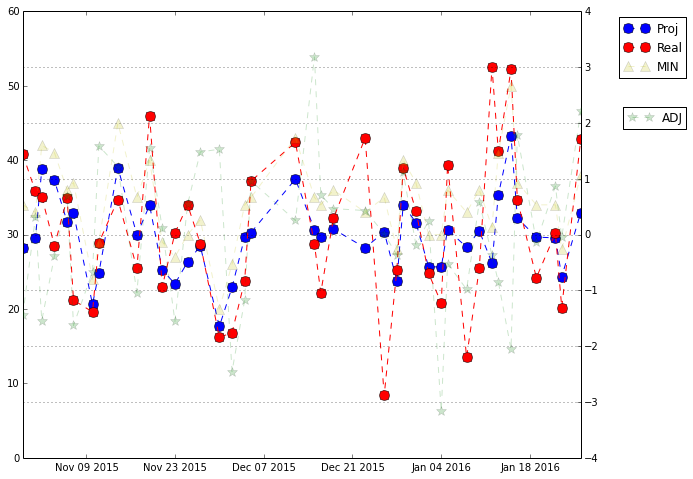

In [117]:
lcf = 'Antetokounmpo, Giannis'
pid = dfsutils.get_pid(lcf)
pt = table[table.Player_ID==pid]

print D.loc[lcf]

fig, ax1 = plt.subplots()
ax1.plot(pt.GAME_DATE, pt.PROJ_UNADJ_FD_MIN*pt.MIN, 'b--o', markersize=10, label='Proj')
ax1.plot(pt.GAME_DATE, pt.FD, 'r--o', markersize=10, label='Real')
ax1.plot(pt.GAME_DATE, pt.MIN, 'y--^', markersize=10, alpha=.2, label='MIN')
plt.legend(bbox_to_anchor=(1.2,1.0))

ax2 = ax1.twinx()
ax2.plot(pt.GAME_DATE, pt.ADJ_MIN*pt.MIN, 'g--*', alpha=.2, markersize=10, label='ADJ')

plt.grid()
plt.legend(bbox_to_anchor=(1.2,.8))
plt.show()

0.100730875079


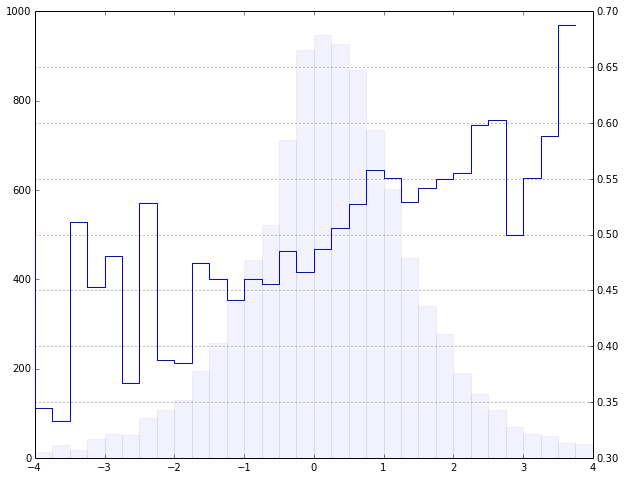

In [132]:
sub = table[table.MIN>20]
print np.corrcoef(sub.ADJ_MIN*sub.MIN, sub.FD-sub.PROJ_UNADJ_FD_MIN*sub.MIN)[0,1]

r = 1.

X = []
Y = []
N = []
dx = .25
for x in np.arange(-4,4,dx):
    I = (sub.ADJ_MIN*sub.MIN > x) & (sub.ADJ_MIN*sub.MIN < x+dx)
    J = sub.FD[I] > r*sub.PROJ_UNADJ_FD_MIN[I]*sub.MIN[I]
    K = J
#     print '%+.2f\t%5d\t%.3f' % (x, len(K), np.mean(K))
    X.append(x)
    Y.append(np.mean(K))
    N.append(sum(I))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.bar(X, N, width=dx, alpha=.05)
ax2.step(X,Y)
plt.xlim([-4,4])
plt.grid()
plt.show()